# Binary black hole detections

Matriculation: 2663452m

## Aims
The aims of this experiment are to procees the gravitational wave data from the first and second runs of the LIGO/Virgo gravitational wave detectors and to discover properties of the binary black hole systems that prodiced the signals.


Gravitational waves were first predicted by Einstien in his 1915 paper on General Relativity but in 2015 the first gravitational wave was detected by the LIGO research group. Gravitational waves arise from the acceleration of two masses in space-time. The first gravitational wave was detected by the LIGO research group in 2015. The LIGO detectors are two large interferometers located in the USA and in Italy. The detectors are designed to detect gravitational waves by measuring the change in the distance between the two mirrors. The mirrors are suspended on a beam of laser light which is reflected back and forth between the mirrors. When a gravitational wave passes through the detectors, the mirrors are accelerated and the distance between the mirrors changes. The change in distance is measured by the laser light and the gravitational wave is detected. The LIGO detectors are two large interferometers located in the USA and in Italy. The detectors are designed to detect gravitational waves by measuring the change in the distance between the two mirrors. The mirrors are suspended on a beam of laser light which is reflected back and forth between the mirrors. When a gravitational wave passes through the detectors, the mirrors are accelerated and the distance between the mirrors changes. The change in distance is measured by the laser light and the gravitational wave is detected. The LIGO detectors are two large interferometers located in the USA and in Italy. The detectors are designed to detect gravitational waves by measuring the change in the distance between the two mirrors. The mirrors are suspended on a beam of laser light which is reflected back and forth between the mirrors. When a gravitational wave passes through the detectors, the mirrors are accelerated and the distance between the mirrors changes. The change in distance is measured by the laser light and the gravitational wave is detected. The LIGO detectors are two large interferometers located in the USA and in Italy. The detectors are designed to detect gravitational waves by measuring the change in the distance between the two mirrors. The mirrors are suspended on a beam of laser light which is reflected back and forth between the mirrors. When a gravitational wave passes through the detectors, the mirrors are accelerated and the distance between the mirrors changes. The change in distance is measured by the laser light and the gravitational wave is detected. The LIGO detectors are two large interferometers located in the USA and in Italy. The detectors are designed to detect gravitational waves by measuring the change in the distance between the two mirrors. The mirrors are suspended on a beam of laser light which is reflected back and forth between the mirrors. When a gravitational wave passes through the detectors, the mirrors are accelerated and the distance between the mirrors changes. The change in distance is measured by the laser light and the gravitational wave is detected. The LIGO detectors

In [50]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
from scipy.optimize import curve_fit
import scipy.optimize as opt
import scipy.constants as const
import os
import lal as lal
from scipy.signal import spectrogram
import gw_detections_functions as gw
import pandas as pd


title_size = 16
axis_size = 12
plt.rcParams["font.family"] = "Times New Roman"


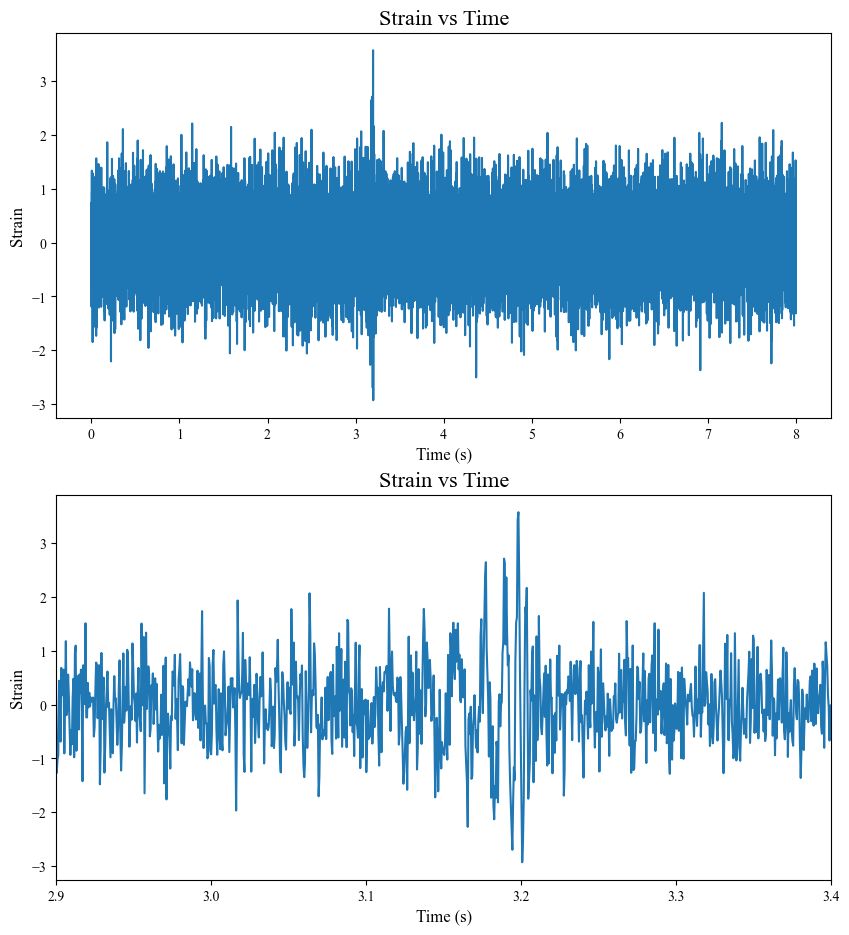

In [51]:
data = np.loadtxt('strain_data/GW150914_strain.txt')
time = data[:,0]
strain = data[:,1]

plt.figure(figsize = (10,11))
plt.subplot(2,1,1)
plt.plot(time, strain)
plt.xlabel('Time (s)', fontsize=axis_size)
plt.ylabel('Strain', fontsize=axis_size)
plt.title('Strain vs Time', fontsize=title_size)

plt.subplot(2,1,2)
plt.plot(time, strain)
plt.xlabel('Time (s)', fontsize=axis_size)
plt.ylabel('Strain', fontsize=axis_size)
plt.title('Strain vs Time', fontsize=title_size)
plt.xlim(2.9,3.4)
plt.show()

The siganl shows a peak in the strain likely as the black holes collide releasing a lot of energy in a short amount of time.

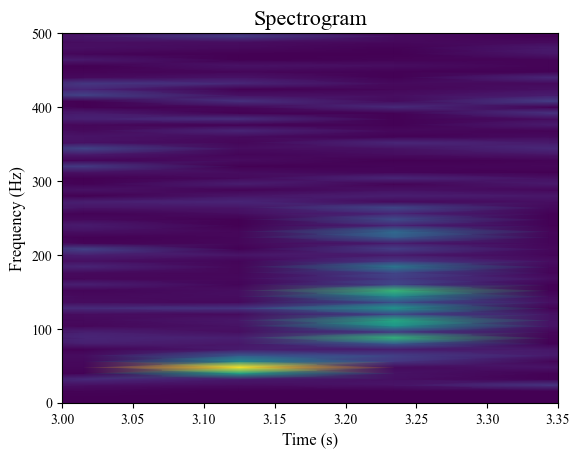

In [52]:
spec_f, spec_t, spec = sp.signal.spectrogram(strain, 2048)
plt.pcolormesh(spec_t, spec_f, spec, shading='gouraud')
plt.ylabel('Frequency (Hz)', fontsize=axis_size)
plt.xlabel('Time (s)', fontsize=axis_size)
plt.xlim(3,3.35)
plt.ylim(0,500)
plt.title('Spectrogram', fontsize=title_size)
plt.show()


reasonable mass of a black hole in merger 7 - 37 solar masses

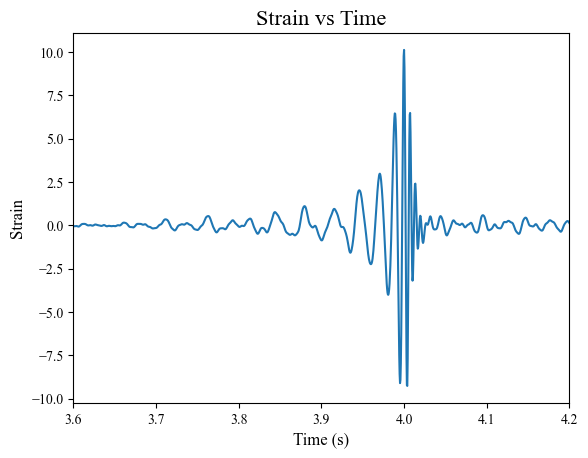

In [53]:
inv_psd = np.loadtxt('inv_psd/GW150914_inv_psd.txt',usecols=(1,))
t, template = gw.make_template(70,36,2048,8,inv_psd,400)

plt.figure()
plt.plot(t, template)
plt.xlabel('Time (s)', fontsize=axis_size)
plt.xlim(3.6,4.2)
plt.ylabel('Strain', fontsize=axis_size)
plt.title('Strain vs Time', fontsize=title_size)
plt.show()


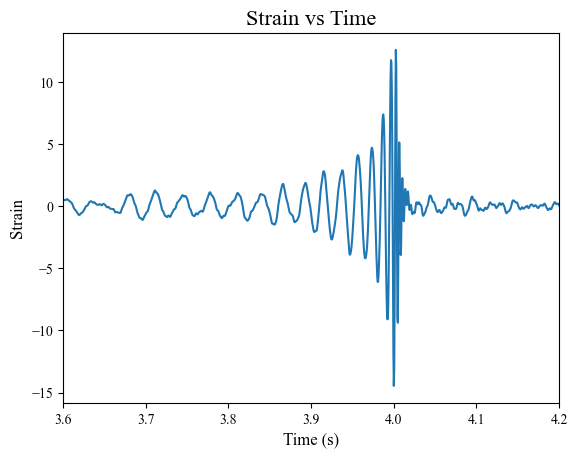

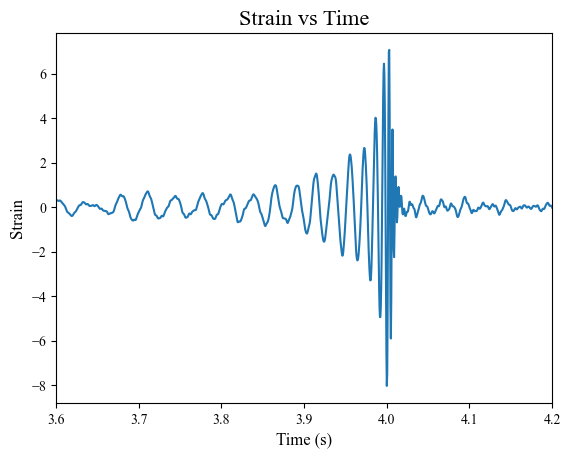

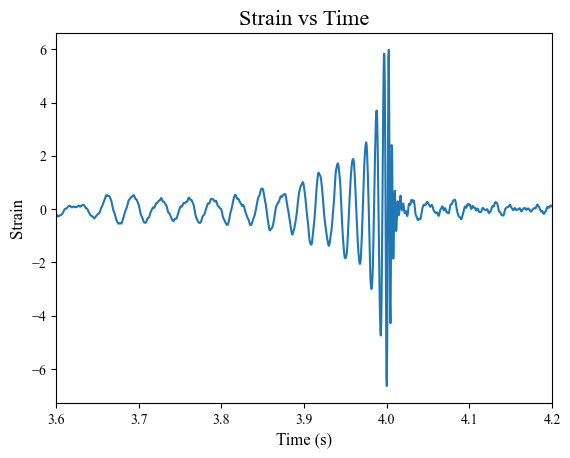

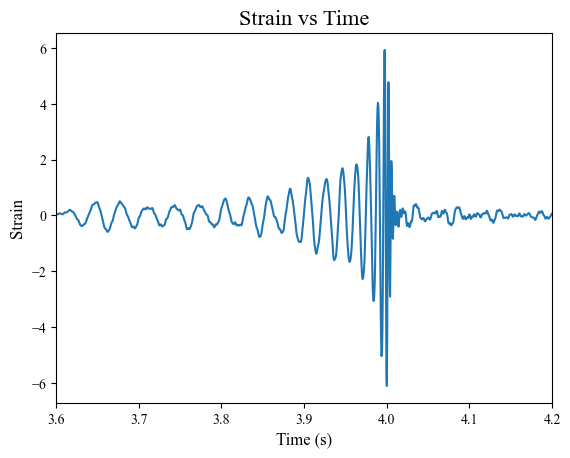

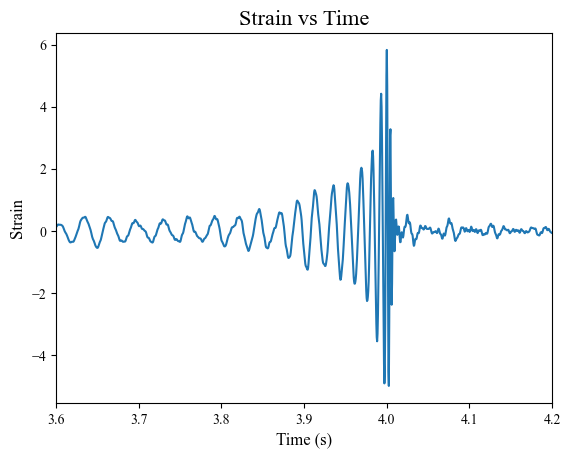

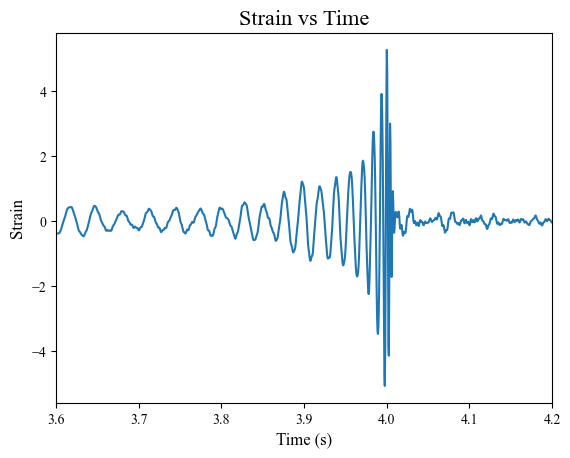

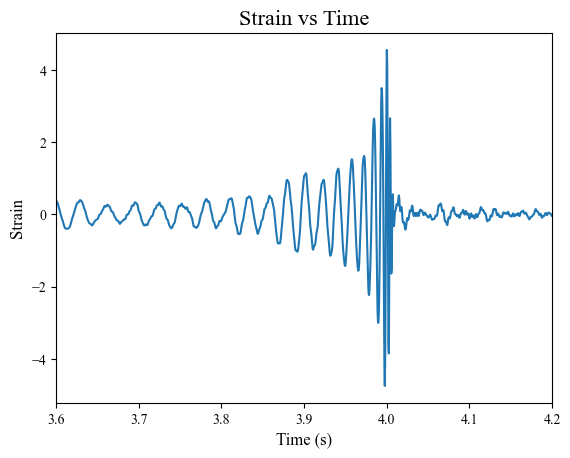

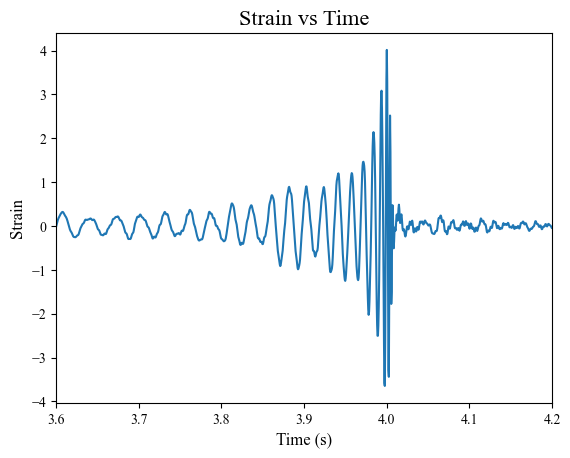

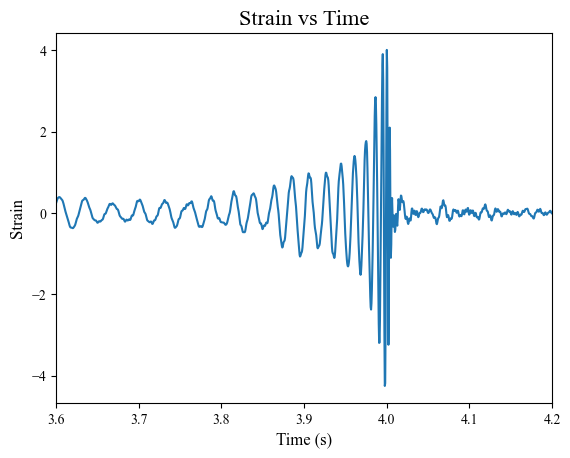

In [54]:
mass_one = [37,38,36,35,34,33,32,31,25]
mass_two = [24,23,22,21,20,19,18,17,24]
mass_three = np.array(mass_one) - 1
distance = [400,500,350,450,430,510,390,200,420]
distance = np.sort(np.array(distance))
for i in range(len(mass_one)):
        t, template = gw.make_template(mass_one[i],mass_two[i],2048,8,inv_psd,distance[i])
        plt.figure()
        plt.plot(t, template)
        plt.xlabel('Time (s)', fontsize=axis_size)
        plt.xlim(3.6,4.2)
        plt.ylabel('Strain', fontsize=axis_size)
        plt.title('Strain vs Time', fontsize=title_size)
        plt.show()



# Task 2

As distance increases the amplitude of the wave decreases.
not much changes for masses that are simlar or different

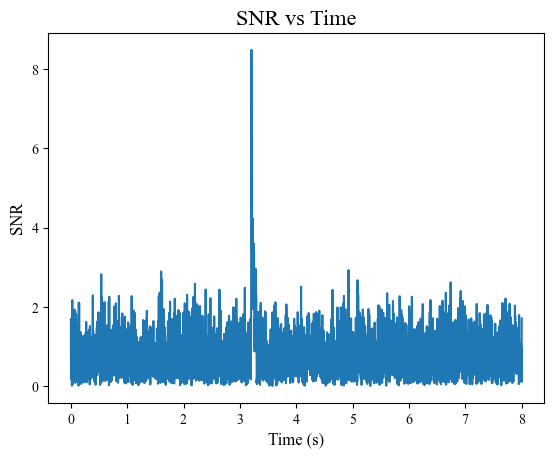

8.482283713317145
(array([6561]),)
[8.48228371] [3.20361328]


In [55]:
snr_ts = gw.get_snr(strain, template, 2048)
plt.figure()
plt.plot(time,snr_ts)
plt.xlabel('Time (s)', fontsize=axis_size)
plt.ylabel('SNR', fontsize=axis_size)
plt.title('SNR vs Time', fontsize=title_size)

plt.show()
print(np.max(snr_ts))
print(np.where(np.max(snr_ts) == snr_ts))
print(snr_ts[np.where(np.max(snr_ts) == snr_ts)],time[np.where(np.max(snr_ts) == snr_ts)])

min_time = time[np.where(np.max(snr_ts) == snr_ts)]-1
max_time = time[np.where(np.max(snr_ts) == snr_ts)]+1


### Part a

13.817943693057638 38.94736842105264 34.8421052631579


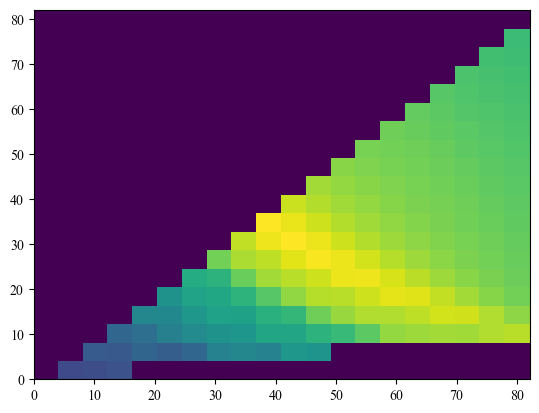

13.826971256610825 37.10526315789474 35.26315789473684


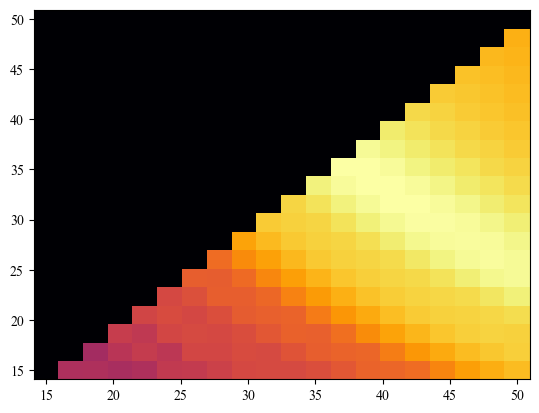

In [56]:
masses = np.linspace(2,80,20)
currentmax = 0
highest_snr = [[0 for x in range(13)] for y in range(13)]
mass1 = [] 
mass2 = [] 
allsnr = []

for m1 in masses:
    for m2 in masses:
        if m1>m2 and (m1/m2) < 8:
            t, template = gw.make_template(m1,m2,2048,8,inv_psd,400)
            snr_ts = gw.get_snr(strain, template, 2048)
            maxsnr = np.max(snr_ts)
            allsnr.append(maxsnr)
            if maxsnr > currentmax:
                currentmax = maxsnr
                M1 = m1
                M2 = m2
        else:
            allsnr.append(0)
print(currentmax, M1, M2)

reshaped = (np.reshape(allsnr, (20,20)).T)
plt.figure()
plt.pcolor(masses, masses, reshaped)
plt.show()

allsnr2 = []
currentmax = 0
masses2 = np.linspace(15,50,20)
maxsnr = []
for m1 in masses2:
    for m2 in masses2:
        if m1>m2 and (m1/m2) < 8:
            t, template = gw.make_template(m1,m2,2048,8,inv_psd,400)
            snr_ts = gw.get_snr(strain, template, 2048)
            maxsnr = np.max(snr_ts)
            allsnr2.append(maxsnr)
            if maxsnr > currentmax:
                currentmax = maxsnr
                M1 = m1
                M2 = m2
        else:
            allsnr2.append(0)
print(currentmax, M1, M2)



reshaped = (np.reshape(allsnr2, (20,20)).T)
plt.figure()
plt.pcolor(masses2, masses2, reshaped, cmap='inferno')
plt.show()

Best fit mass pair for snr result is 36,35 solar masses

### Part b

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


The best fit parameters for distance, time, and phase are 1999.9999999999998, 3.1920867981038, and 2.0435865162603473 respectively.


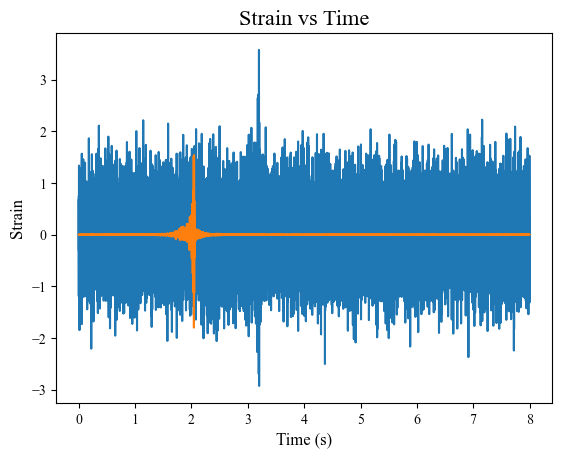

In [57]:
mass1 = M1
mass2 = M2
def make_signal(t,d,tc,phic):
    _,signal = gw.make_template(mass1,mass2,2048,8,inv_psd,d=d,tc=tc,phic=phic)
    return signal
t = 8
distances = np.array(np.linspace(100,10000,10000))
tc_min = min_time
tc_max = max_time
phic_min = 0
phic_max = 2*np.pi
d_min = 100
d_max = 2000
#p0 = [890,(time[np.where(np.max(snr_ts) == snr_ts)]),5]


ht_err = np.array(np.ones(strain.size))
b = np.array([[d_min,tc_min,phic_min],[d_max,tc_max,phic_max]], dtype = object)
popt, pcov = curve_fit(make_signal,time ,strain, p0 = [890,time[(np.where(np.max(snr_ts) == snr_ts),)],5],bounds = b, sigma=ht_err, absolute_sigma=True)

t, template = gw.make_template(mass1,mass2,2048,8,inv_psd,popt[0],popt[1],popt[2])

print(f'The best fit parameters for distance, time, and phase are {popt[0]}, {popt[1]}, and {popt[2]} respectively.')
plt.figure()
plt.plot(time, strain)
plt.plot(time, template)
plt.xlabel('Time (s)', fontsize=axis_size)
plt.ylabel('Strain', fontsize=axis_size)
plt.title('Strain vs Time', fontsize=title_size)
plt.show()

------------------------------------------------------------
GW150914_strain.txt


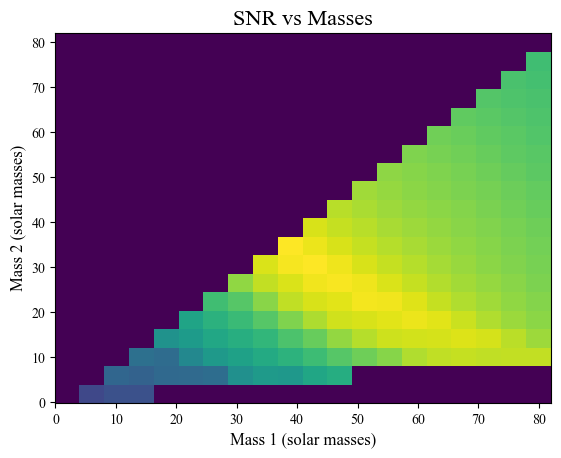

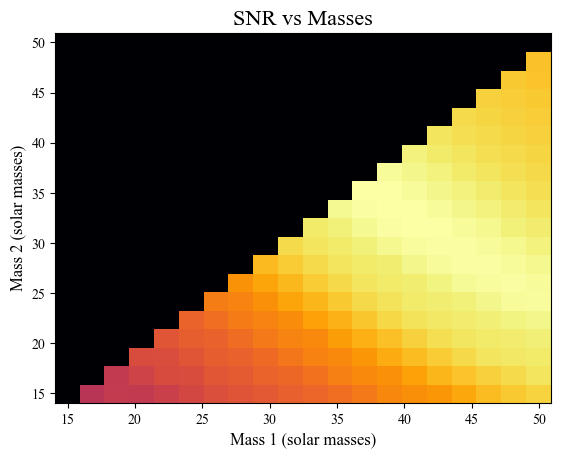

The best fit masses for GW170823_inv_psd.txt are 37.10526315789474 and 35.26315789473684 respectively.
[[3.19091797]]


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


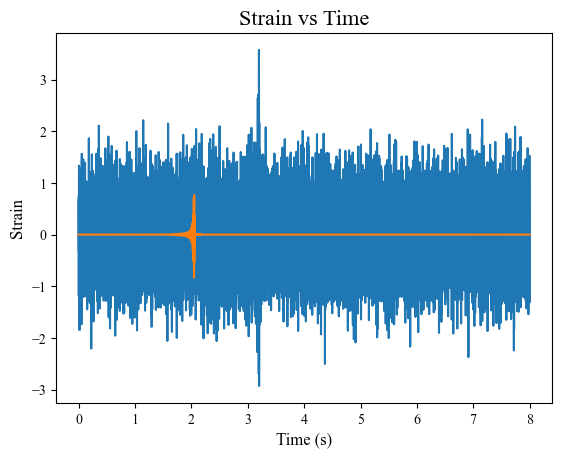

The best fit parameters for data set GW170823_inv_psd.txt for distance, time, and phase are 4499.999999999999, 3.1920834233058213, and 2.04529730271242 respectively.
------------------------------------------------------------
GW170823_strain.txt


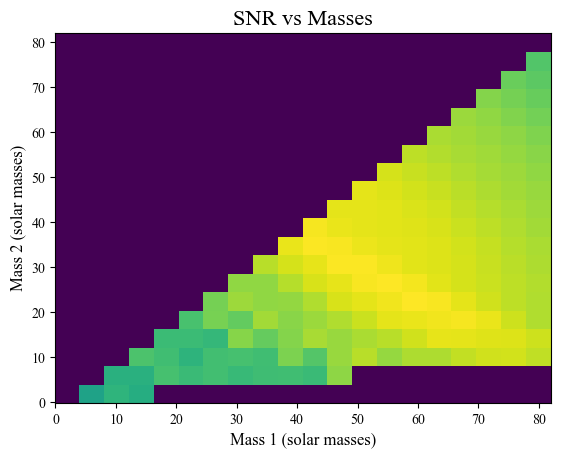

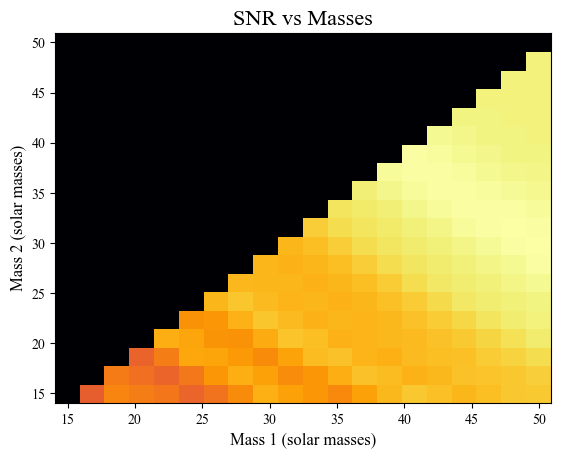

The best fit masses for GW170823_inv_psd.txt are 50.0 and 29.736842105263158 respectively.
[[4.45361328]]


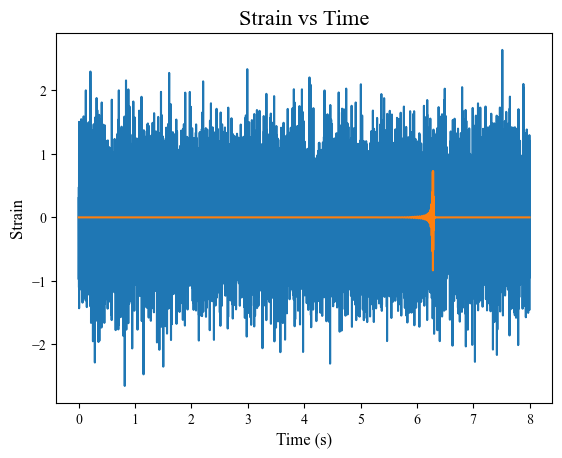

The best fit parameters for data set GW170823_inv_psd.txt for distance, time, and phase are 4499.9999999977135, 4.4513284725549385, and 6.283184883031562 respectively.
------------------------------------------------------------
GW170814_strain.txt


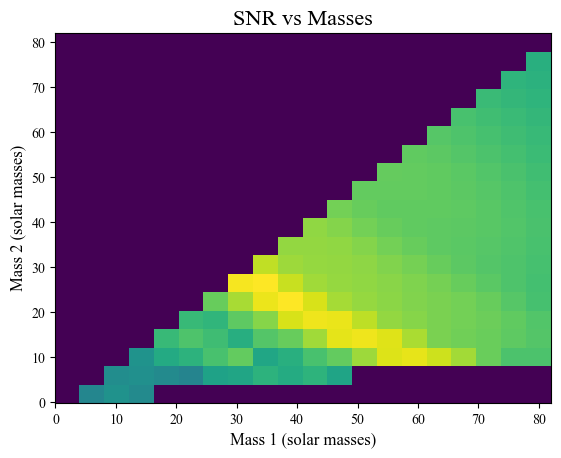

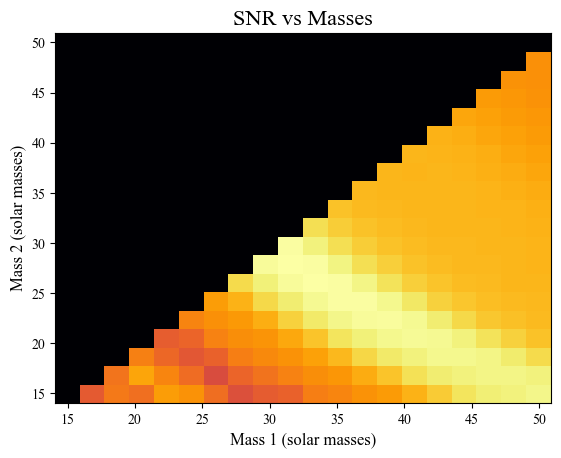

The best fit masses for GW170823_inv_psd.txt are 31.57894736842105 and 27.894736842105264 respectively.
[[3.32666016]]


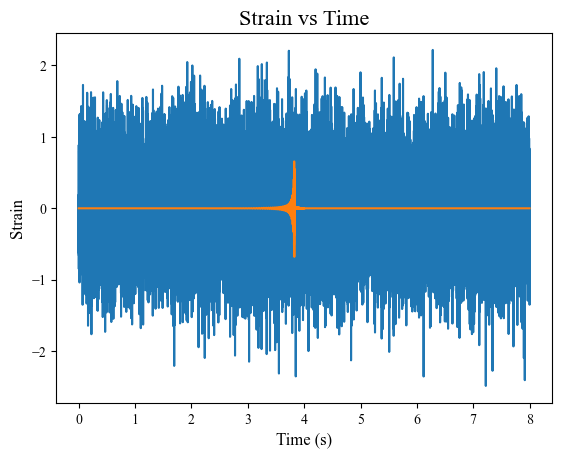

The best fit parameters for data set GW170823_inv_psd.txt for distance, time, and phase are 4499.999999999999, 3.3283673452487763, and 3.8255027201164005 respectively.
------------------------------------------------------------
GW170104_strain.txt


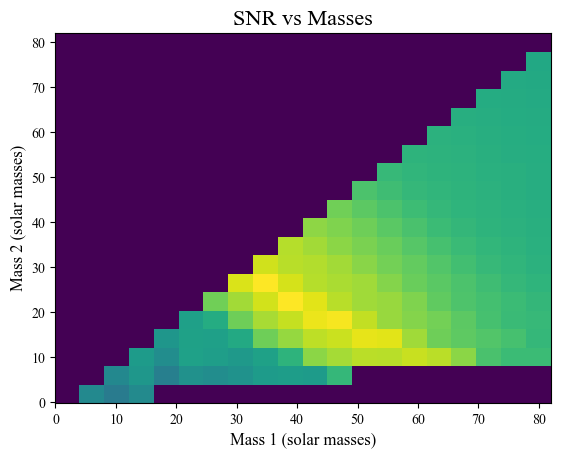

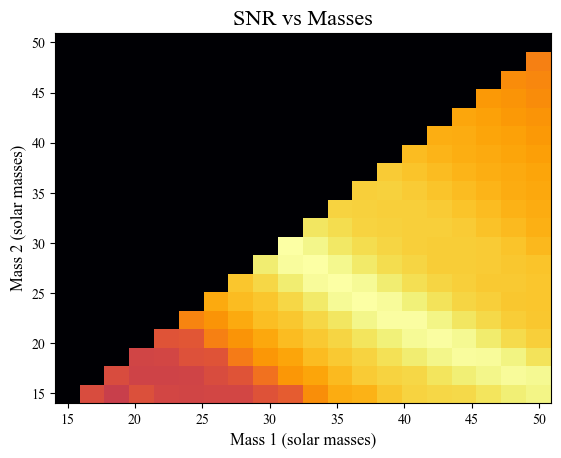

The best fit masses for GW170823_inv_psd.txt are 35.26315789473684 and 26.05263157894737 respectively.
[[1.96533203]]


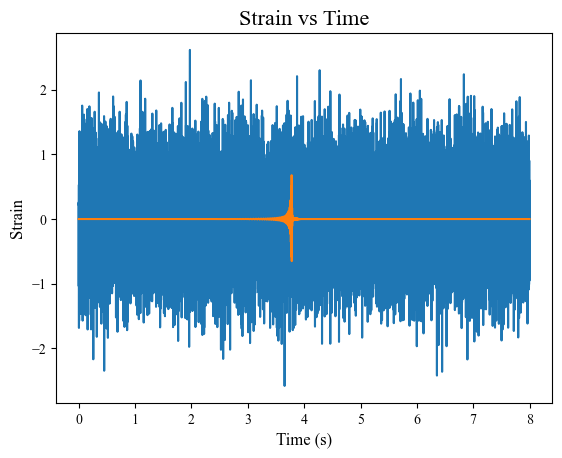

The best fit parameters for data set GW170823_inv_psd.txt for distance, time, and phase are 4499.999999999999, 1.9681790435546678, and 3.777976776760288 respectively.
------------------------------------------------------------
GW151226_strain.txt


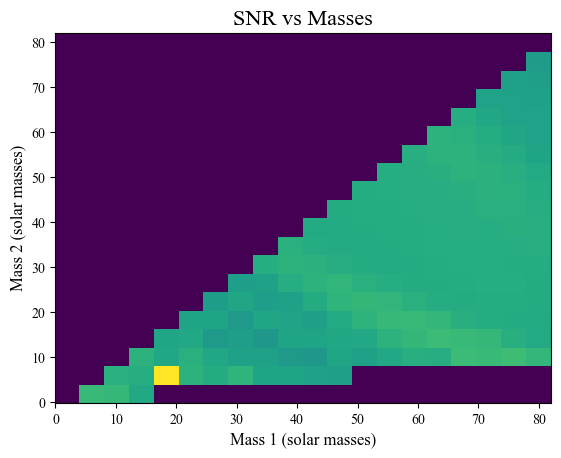

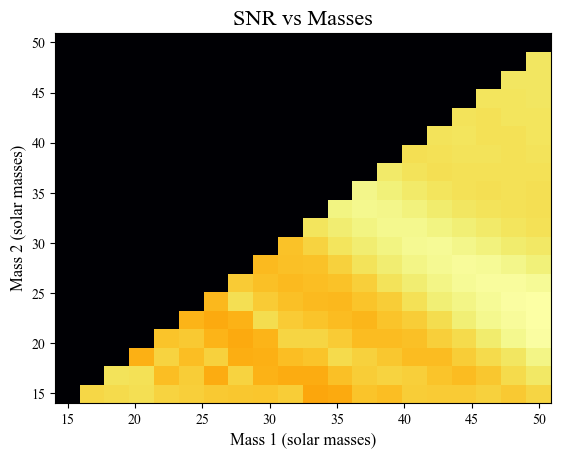

The best fit masses for GW170823_inv_psd.txt are 50.0 and 24.210526315789473 respectively.
[[5.97363281]]


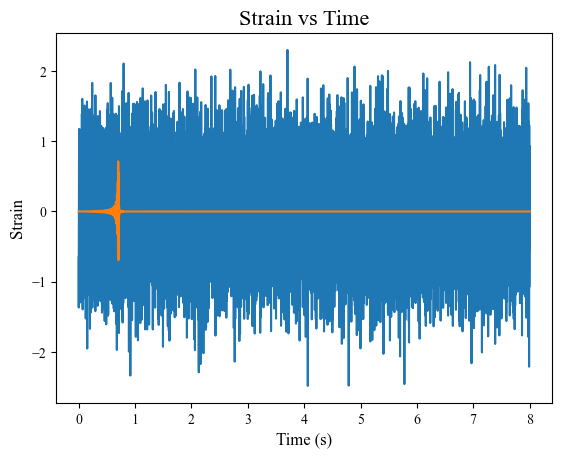

The best fit parameters for data set GW170823_inv_psd.txt for distance, time, and phase are 4448.4924813014, 5.979277765135801, and 0.7019928913673674 respectively.
------------------------------------------------------------
GW151012_strain.txt


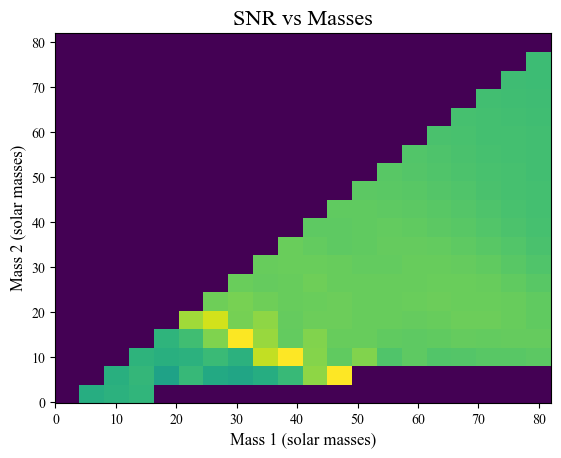

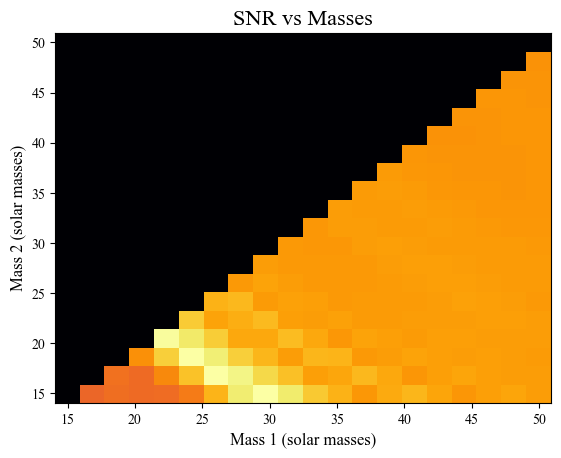

The best fit masses for GW170823_inv_psd.txt are 29.736842105263158 and 15.0 respectively.
[[2.69384766]]


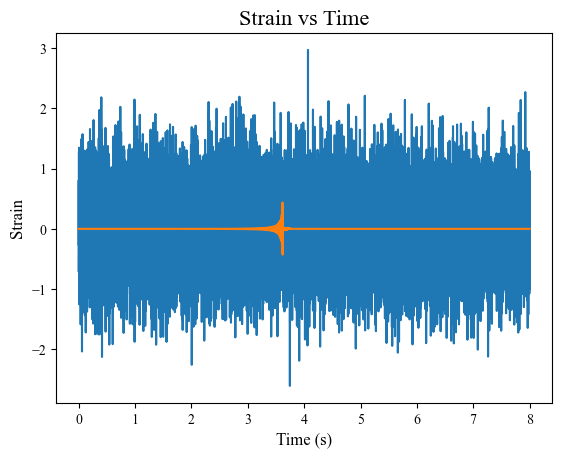

The best fit parameters for data set GW170823_inv_psd.txt for distance, time, and phase are 4499.999999999999, 2.6950244494427844, and 3.6171014265490897 respectively.
------------------------------------------------------------
GW170817_strain.txt
------------------------------------------------------------
GW170729_strain.txt


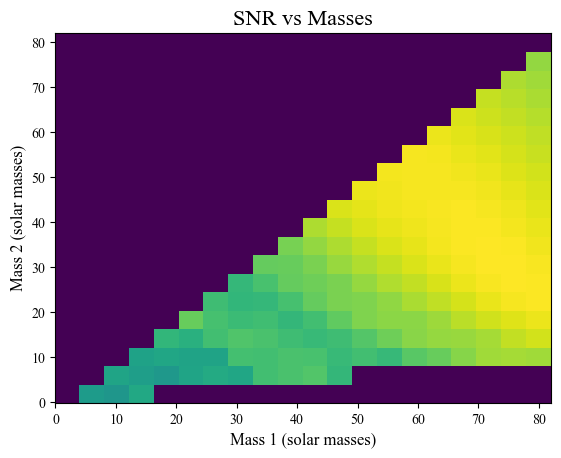

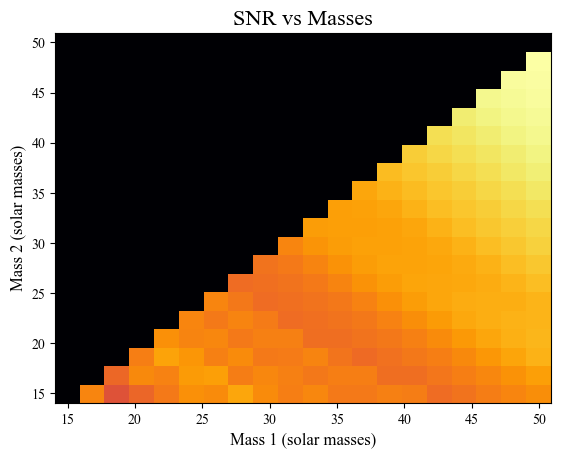

The best fit masses for GW170823_inv_psd.txt are 50.0 and 48.1578947368421 respectively.
[[3.54003906]]


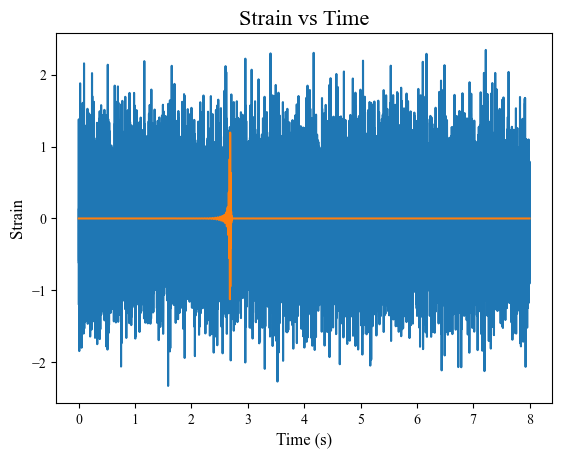

The best fit parameters for data set GW170823_inv_psd.txt for distance, time, and phase are 3875.432304477035, 3.5400559763422805, and 2.682156908076068 respectively.
------------------------------------------------------------
.ipynb_checkpoints


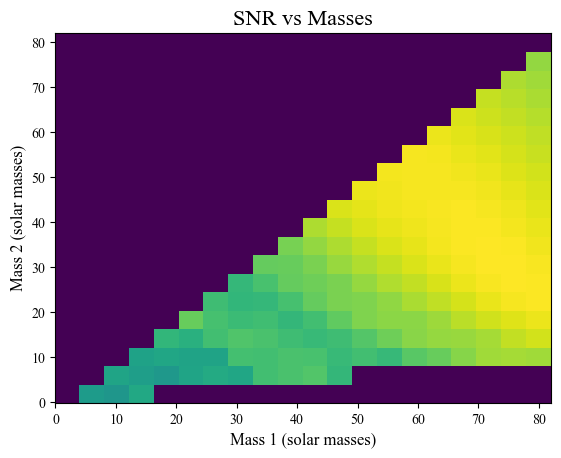

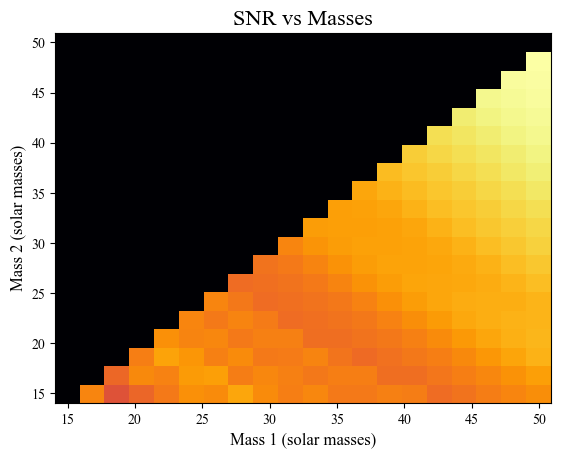

The best fit masses for GW170823_inv_psd.txt are 50.0 and 48.1578947368421 respectively.
[[3.54003906]]


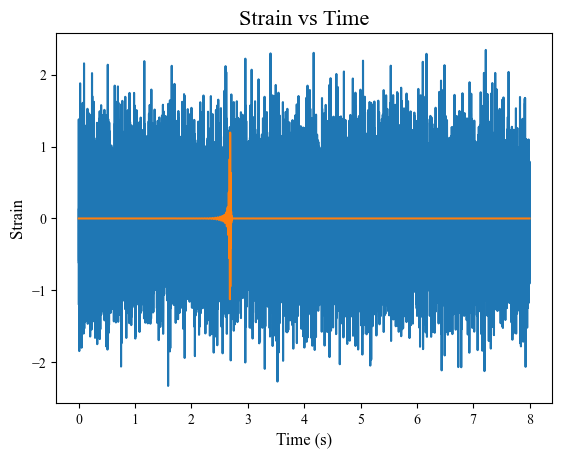

The best fit parameters for data set GW170823_inv_psd.txt for distance, time, and phase are 3875.432304477035, 3.5400559763422805, and 2.682156908076068 respectively.
------------------------------------------------------------
GW170809_strain.txt


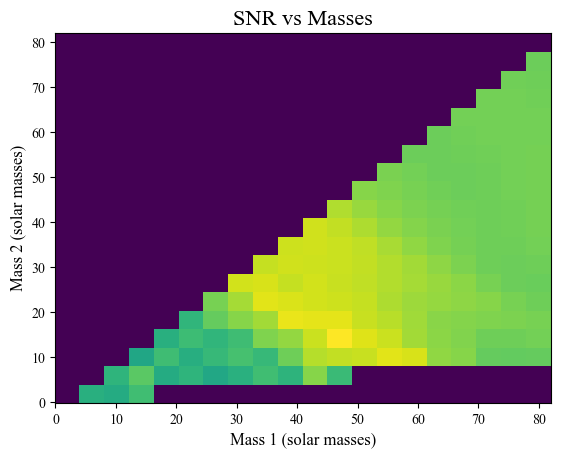

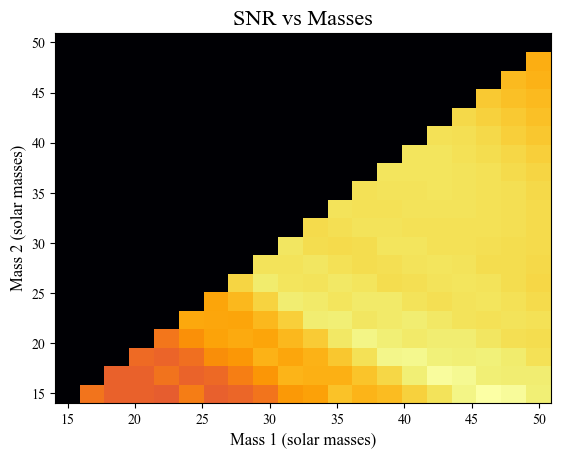

The best fit masses for GW170823_inv_psd.txt are 46.315789473684205 and 15.0 respectively.
[[2.63183594]]


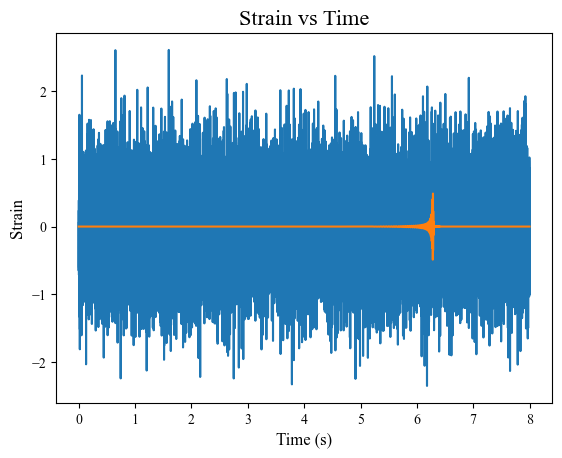

The best fit parameters for data set GW170823_inv_psd.txt for distance, time, and phase are 4499.999999999999, 2.633178093625321, and 6.283185228558428 respectively.
------------------------------------------------------------
GW170818_strain.txt


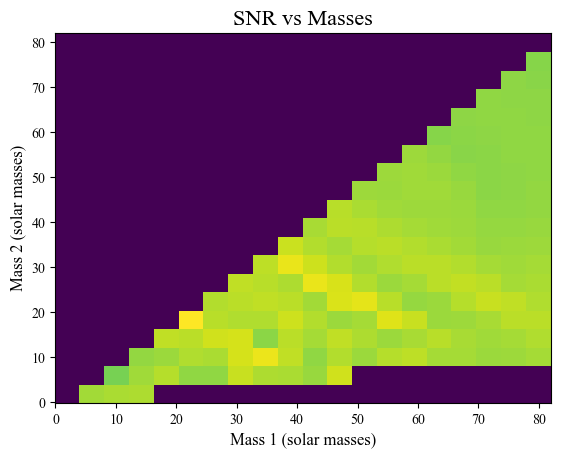

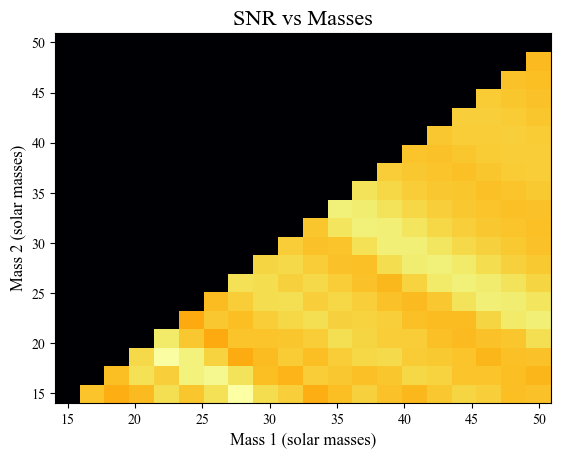

The best fit masses for GW170823_inv_psd.txt are 27.894736842105264 and 15.0 respectively.
[[3.75146484]]


ValueError: `x0` is infeasible.

In [59]:
path = 'strain_data/'
files = os.listdir(path)

distance_coel = [] 
time_coel = []
phase_coel = [] 
larger_masses = []
smaller_masses = []


for file in files:
    filename = path+file
    print('------------------------------------------------------------')
    print(file)
    if file.startswith('GW170817'):
        pass
    else:
        if file.endswith('strain.txt'):
            data = np.loadtxt(filename)
            time = data[:,0]
            strain = data[:,1]
        for file in os.listdir('inv_psd/'):
            if file.endswith('inv_psd.txt'):
                inv_psd_data = np.loadtxt('inv_psd/'+file)
                inv_psd2 = inv_psd_data[:,1]
            
        t, template = gw.make_template(37,36,2048,8,inv_psd2,400)
        snr_ts = gw.get_snr(strain, template, 2048)
        min_time = time[np.where(np.max(snr_ts) == snr_ts)]-1
        max_time = time[np.where(np.max(snr_ts) == snr_ts)]+0.5

        masses = np.linspace(2,80,20)
        currentmax = 0
        highest_snr = [[0 for x in range(13)] for y in range(13)]
        mass1 = [] 
        mass2 = [] 
        allsnr = []

        for m1 in masses:
            for m2 in masses:
                if m1>m2 and (m1/m2) < 8:
                    t, template = gw.make_template(m1,m2,2048,8,inv_psd2,400)
                    snr_ts = gw.get_snr(strain, template, 2048)
                    maxsnr = np.max(snr_ts)
                    allsnr.append(maxsnr)
                    if maxsnr > currentmax:
                        currentmax = maxsnr
                        M1 = m1
                        M2 = m2

                else:
                    allsnr.append(0)
        reshaped = (np.reshape(allsnr, (20,20)).T)
        plt.figure()
        plt.title('SNR vs Masses', fontsize=title_size)
        plt.xlabel('Mass 1 (solar masses)', fontsize=axis_size)
        plt.ylabel('Mass 2 (solar masses)', fontsize=axis_size)
        plt.pcolor(masses, masses, reshaped)
        plt.show()

        allsnr2 = []
        currentmax = 0
        masses2 = np.linspace(15,50,20)
        maxsnr = []
        for m1 in masses2:
            for m2 in masses2:
                if m1>m2 and (m1/m2) < 8:
                    t, template = gw.make_template(m1,m2,2048,8,inv_psd2,400)
                    snr_ts = gw.get_snr(strain, template, 2048)
                    maxsnr = np.max(snr_ts)
                    allsnr2.append(maxsnr)
                    if maxsnr > currentmax:
                        currentmax = maxsnr
                        M1 = m1
                        M2 = m2
                else:
                    allsnr2.append(0)

        reshaped = (np.reshape(allsnr2, (20,20)).T)
        plt.figure()
        plt.title('SNR vs Masses', fontsize=title_size)
        plt.xlabel('Mass 1 (solar masses)', fontsize=axis_size)
        plt.ylabel('Mass 2 (solar masses)', fontsize=axis_size)
        plt.pcolor(masses2, masses2, reshaped, cmap='inferno')
        plt.show()
        
        def make_signal(t,d,tc,phic):
            _,signal = gw.make_template(M1,M2,2048,8,inv_psd,d=d,tc=tc,phic=phic)
            return signal
        t = 8
        distances = np.array(np.linspace(100,10000,10000))
        tc_min = min_time
        tc_max = max_time
        phic_min = 0
        phic_max = 2*np.pi
        d_min = 100
        d_max = 4500
        print(f'The best fit masses for {file} are {M1} and {M2} respectively.')
        print(time[(np.where(np.max(snr_ts) == snr_ts),)])
        ht_err = np.array(np.ones(strain.size))
        b = np.array([[d_min,tc_min,phic_min],[d_max,tc_max,phic_max]], dtype = object)
        popt, pcov = curve_fit(make_signal,time ,strain, p0 = [890,time[(np.where(np.max(snr_ts) == snr_ts),)],5],bounds = b, sigma=ht_err, absolute_sigma=True)

        distance_coel.append(popt[0])
        time_coel.append(popt[1])
        phase_coel.append(popt[2])
        larger_masses.append(M1)
        smaller_masses.append(M2)

        t, template = gw.make_template(M1,M2,2048,8,inv_psd2,popt[0],popt[1],popt[2])

        plt.figure()
        plt.plot(time, strain)
        plt.plot(time, template)
        plt.xlabel('Time (s)', fontsize=axis_size)
        plt.ylabel('Strain', fontsize=axis_size)
        plt.title('Strain vs Time', fontsize=title_size)
        plt.show()
        
        print(f'The best fit parameters for data set {file} for distance, time, and phase are {popt[0]}, {popt[1]}, and {popt[2]} respectively.')
        # print(currentmax, M1, M2)


In [ ]:
df = pd.DataFrame({'Distance (Mpc)':distance_coel, 'Time (s)':time_coel, 'Phase (radians)':phase_coel, 'Larger Mass (solar masses)':larger_masses, 'Smaller Mass (solar masses)':smaller_masses})
df.to_csv('coel_data.csv')
df

,Distance (Mpc),Time (s),Phase (radians),Larger Mass (solar masses),Smaller Mass (solar masses)
0,4500.000000,3.192083,2.045297,37.105263,35.263158
1,4500.000000,4.451328,6.283185,50.000000,29.736842
2,4500.000000,3.328367,3.825503,31.578947,27.894737
3,4500.000000,1.968179,3.777977,35.263158,26.052632
4,4448.492481,5.979278,0.701993,50.000000,24.210526
5,4500.000000,2.695024,3.617101,29.736842,15.000000
6,3875.432304,3.540056,2.682157,50.000000,48.157895
7,3875.432304,3.540056,2.682157,50.000000,48.157895
8,4500.000000,2.633178,6.283185,46.315789,15.000000


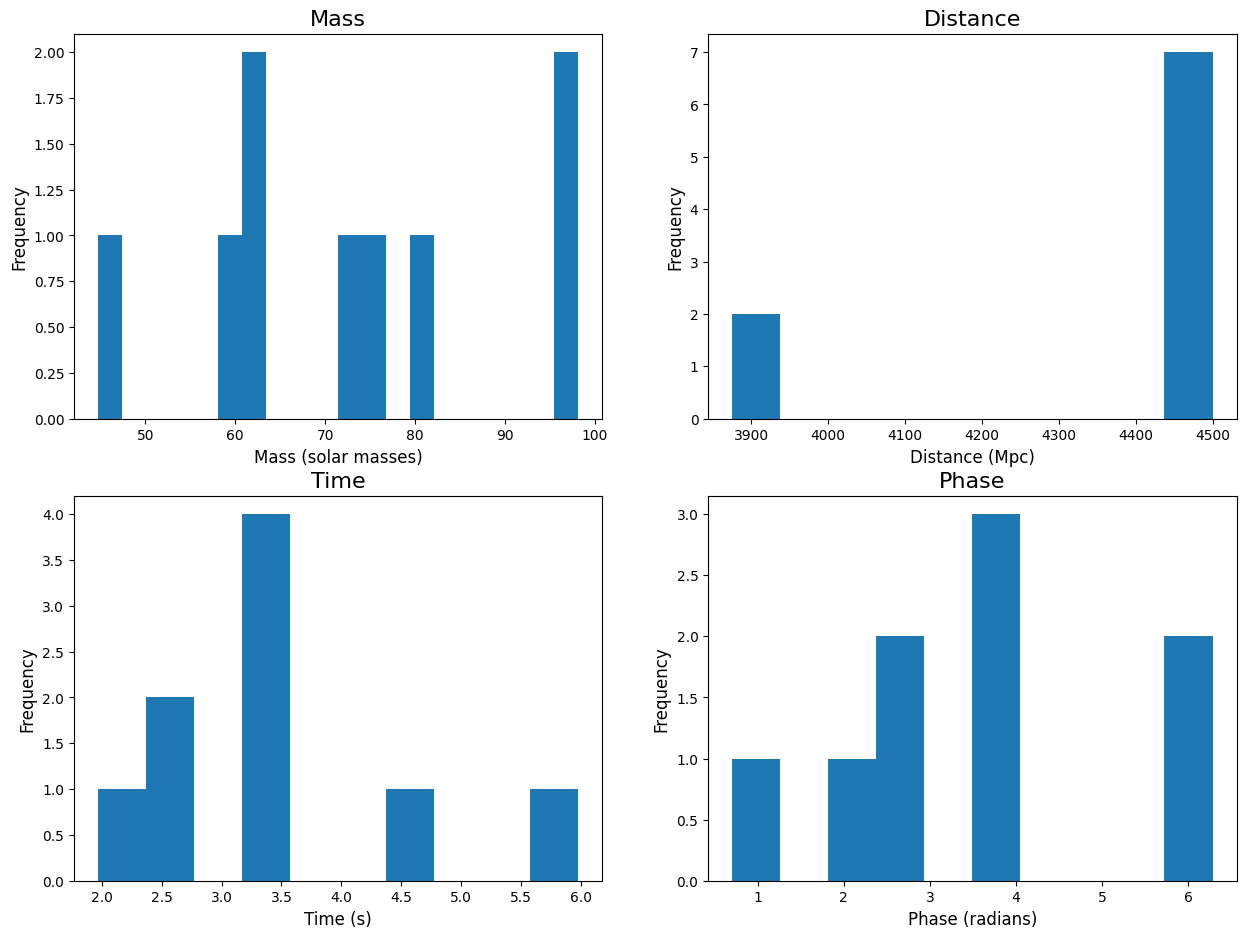

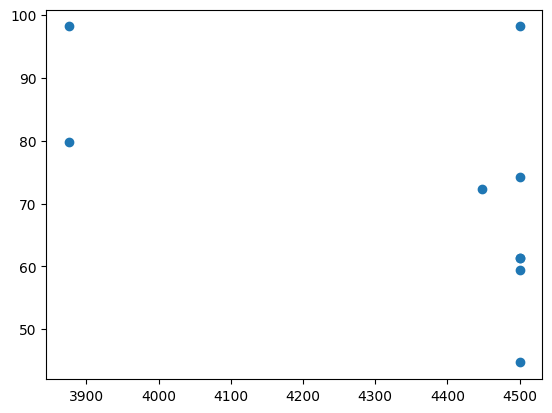

In [ ]:
all_masses = np.array(larger_masses) + np.array(smaller_masses)
all_masses = np.sort(all_masses)

plt.figure(figsize = (15,11))
plt.subplot(2,2,1)
plt.hist(all_masses, bins=20)
plt.xlabel('Mass (solar masses)', fontsize=axis_size)
plt.ylabel('Frequency', fontsize=axis_size)
plt.title('Mass', fontsize=title_size)

plt.subplot(2,2,3)
plt.hist(time_coel, bins=10)
plt.xlabel('Time (s)', fontsize=axis_size)
plt.ylabel('Frequency', fontsize=axis_size)
plt.title('Time', fontsize=title_size)

plt.subplot(2,2,2)
plt.hist(distance_coel, bins=10)
plt.xlabel('Distance (Mpc)', fontsize=axis_size)
plt.ylabel('Frequency', fontsize=axis_size)
plt.title('Distance', fontsize=title_size)

plt.subplot(2,2,4)
plt.hist(phase_coel, bins=10)
plt.xlabel('Phase (radians)', fontsize=axis_size)
plt.ylabel('Frequency', fontsize=axis_size)
plt.title('Phase', fontsize=title_size)
plt.show()

plt.figure()
plt.scatter(distance_coel, all_masses)
plt.show()



(18,)


In [ ]:
      
    # data = np.loadtxt('data_files/GW150914_strain.txt')
    # time = data[:,0]
    # strain = data[:,1]


    # inv_psd = np.loadtxt('data_files/GW150914_inv_psd.txt',usecols=(1,))
    # t, template = gw.make_template(37,36,2048,8,inv_psd,400)



    # snr_ts = gw.get_snr(strain, template, 2048)
    # min_time = time[np.where(np.max(snr_ts) == snr_ts)]-1
    # max_time = time[np.where(np.max(snr_ts) == snr_ts)]+1



    # masses = np.linspace(2,80,50)
    # currentmax = 0
    # highest_snr = [[0 for x in range(13)] for y in range(13)]
    # mass1 = [] 
    # mass2 = [] 
    # allsnr = []

    # for m1 in masses:
    #     for m2 in masses:
    #         if m1>m2 and (m1/m2) < 8:
    #             t, template = gw.make_template(m1,m2,2048,8,inv_psd,400)
    #             snr_ts = gw.get_snr(strain, template, 2048)
    #             maxsnr = np.max(snr_ts)
    #             allsnr.append(maxsnr)
    #             if maxsnr > currentmax:
    #                 currentmax = maxsnr
    #                 M1 = m1
    #                 M2 = m2
    #         else:
    #             allsnr.append(0)
    # print(currentmax, M1, M2)

    # reshaped = (np.reshape(allsnr, (50,50)).T)
    # plt.figure()
    # plt.pcolor(masses, masses, reshaped)
    # plt.show()

    # allsnr2 = []
    # currentmax = 0
    # masses2 = np.linspace(15,50,50)
    # maxsnr = []
    # for m1 in masses2:
    #     for m2 in masses2:
    #         if m1>m2 and (m1/m2) < 8:
    #             t, template = gw.make_template(m1,m2,2048,8,inv_psd,400)
    #             snr_ts = gw.get_snr(strain, template, 2048)
    #             maxsnr = np.max(snr_ts)
    #             allsnr2.append(maxsnr)
    #             if maxsnr > currentmax:
    #                 currentmax = maxsnr
    #                 M1 = m1
    #                 M2 = m2
    #         else:
    #             allsnr2.append(0)
    # print(currentmax, M1, M2)



    # reshaped = (np.reshape(allsnr2, (50,50)).T)
    # plt.figure()
    # plt.pcolor(masses2, masses2, reshaped, cmap='inferno')
    # plt.show()


    # mass1 = M1
    # mass2 = M2
    # def make_signal(t,d,tc,phic):
    #     _,signal = gw.make_template(mass1,mass2,2048,8,inv_psd,d=d,tc=tc,phic=phic)
    #     return signal
    # t = 8
    # distances = np.array(np.linspace(100,10000,10000))
    # tc_min = min_time
    # tc_max = max_time
    # phic_min = 0
    # phic_max = 2*np.pi
    # d_min = 100
    # d_max = 2000
    # #p0 = [890,(time[np.where(np.max(snr_ts) == snr_ts)]),5]


    # ht_err = np.array(np.ones(strain.size))
    # b = np.array([[d_min,tc_min,phic_min],[d_max,tc_max,phic_max]], dtype = object)
    # popt, pcov = curve_fit(make_signal,time ,strain, p0 = [890,time[(np.where(np.max(snr_ts) == snr_ts),)],5],bounds = b, sigma=ht_err, absolute_sigma=True)

    # t, template = gw.make_template(mass1,mass2,2048,8,inv_psd,popt[0],popt[1],popt[2])

    # print(f'The best fit parameters for distance, time, and phase are {popt[0]}, {popt[1]}, and {popt[2]} respectively.')
    # plt.figure()
    # plt.plot(time, strain)
    # plt.plot(time, template)
    # plt.xlabel('Time (s)', fontsize=axis_size)
    # plt.ylabel('Strain', fontsize=axis_size)
    # plt.title('Strain vs Time', fontsize=title_size)
    # #plt.xlim(2.9,3.4)
    # plt.show()

# Task 2 part a brute force method


In [ ]:
masses = np.linspace(2,80,13)
highest_snr = []
mass1 = [] 
mass2 = [] 


for m1 in masses:
    for m2 in masses:
        if m1>m2 and (m1/m2) < 8:
            t, template = gw.make_template(m1,m2,2048,8,inv_psd,400)
            snr_ts = gw.get_snr(strain, template, 2048)
            highest_snr.append(np.max(snr_ts))
            mass1.append(m1)
            mass2.append(m2)

#print(len(highest_snr))
sorted_snr = np.sort(highest_snr)
n=20
rslt = sorted_snr[-n:]

# print(rslt)
for i in range(n):
    indexes = np.where(highest_snr == rslt[i])
    final_mass1
    print(mass1[indexes[0][0]],mass2[indexes[0][0]])
    # print(mass1[indexes[0][0]],mass2[indexes[0][0]])

masses = np.linspace(15,70,20)
highest_snr = []
mass1 = [] 
mass2 = [] 


for m1 in masses:
    for m2 in masses:
        if m1>m2 and (m1/m2) < 8:
            t, template = gw.make_template(m1,m2,2048,8,inv_psd,400)
            snr_ts = gw.get_snr(strain, template, 2048)
            highest_snr.append(np.max(snr_ts))
            mass1.append(m1)
            mass2.append(m2)

#print(len(highest_snr))
sorted_snr = np.sort(highest_snr)
n=20
rslt = sorted_snr[-n:]

# print(rslt)
for i in range(n):
    indexes = np.where(highest_snr == rslt[i])
    #print(mass1[indexes[0][0]],mass2[indexes[0][0]])
    # print(mass1[indexes[0][0]],mass2[indexes[0][0]])
    


masses = np.linspace(33,40,200)
highest_snr = []
mass1 = [] 
mass2 = [] 


for m1 in masses:
    for m2 in masses:
        if m1>m2 and (m1/m2) < 8:
            t, template = gw.make_template(m1,m2,2048,8,inv_psd,400)
            snr_ts = gw.get_snr(strain, template, 2048)
            highest_snr.append(np.max(snr_ts))
            mass1.append(m1)
            mass2.append(m2)

#print(len(highest_snr))
sorted_snr = np.sort(highest_snr)
n=20
rslt = sorted_snr[-n:]

# print(rslt)
for i in range(n):
    indexes = np.where(highest_snr == rslt[i])
    print(mass1[indexes[0][0]],mass2[indexes[0][0]])
    # print(mass1[indexes[0][0]],mass2[indexes[0][0]])


In [ ]:
# for m1 in mass1:
#     for m2 in mass2:
#           if m1>m2 and (m1/m2) < 8:
#             t, template = gw.make_template(m1,m2,2048,8,inv_psd,400)
#             snr_ts = gw.get_snr(strain, template, 2048)
#             highest_snr.append(np.max(snr_ts))
#             mass1_2.append(m1)
#             mass2_2.append(m2)
